In [1]:
import os
import os.path as op
from pathlib import Path
import logging
import numpy as np
from skimage import io
import warnings
import random
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

2023-12-11 14:25:05.059233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 14:25:05.059322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 14:25:05.060194: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 14:25:05.067464: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 14:25:06.025044: W tensorflow/compiler/tf2

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data/')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [4]:
translator = RandomTranslation(height_factor=0.1, width_factor=0.1) # Random translation layer
def augment_image(image, label):
    # Random zoom
    zoom_factor = random.random()
    # Ensure the crop size is an integer and do not crop more than 66% of the image
    crop_height = int(99 * zoom_factor) if zoom_factor >= 0.66 else 100 
    crop_width = int(99 * zoom_factor) if zoom_factor >= 0.66 else 100
    # Crop the zoomed size
    image = tf.image.random_crop(image, size=[crop_height, crop_width, 3])
    # Resize to 100 x 100
    image = tf.image.resize(image, size=[100, 100])
    # Randomly flip the image horizontally and vertically
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # Randomly adjust the brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.0)
    # Randomly rotate the image
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Translation
    image = translator(image, training=True)

    return image, label

def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        # label_str = label.numpy().decode('utf-8')
        img = Image.open(img_loc_str).convert('RGB')
        img = np.array(img)
        img = tf.image.resize(img, [100, 100])
        img = img / 255.0

        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    X.set_shape([100, 100, 3])
    y.set_shape([]) # Scalar label

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.map(augment_image)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)


2023-12-11 14:25:07.701571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30315 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:21:00.0, compute capability: 7.0


CNN Model

In [5]:
# Input layer
inputs = Input(shape=(100, 100, 3))

# First convolutional block
x = Conv2D(32, (3, 3), kernel_regularizer=l2(0.01))(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Second convolutional block
x = Conv2D(64, (3, 3), kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Third convolutional block
x = Conv2D(128, (3, 3), kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Dense layer
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)

# Creating the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 98, 98, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496 

In [6]:
# Setting up model saving and early stopping mechanisms
save_best_model = ModelCheckpoint(filepath='best_model_cnn.h5', monitor='val_loss', verbose=1, save_only_best=True, mode='min')
stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model with the dataset
cnn_history = model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[save_best_model, stop_early])

Epoch 1/20


2023-12-11 14:25:09.460765: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-11 14:25:09.657050: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-11 14:25:10.242213: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-11 14:25:10.387990: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


928/928 [==============================] - ETA: 0s - loss: 4.3564 - accuracy: 0.6034
Epoch 1: saving model to best_model_cnn.h5
928/928 [==============================] - 158s 167ms/step - loss: 4.3564 - accuracy: 0.6034 - val_loss: 4.1027 - val_accuracy: 0.5998
Epoch 2/20
926/928 [============================>.] - ETA: 0s - loss: 3.9493 - accuracy: 0.6344
Epoch 2: saving model to best_model_cnn.h5
928/928 [==============================] - 146s 156ms/step - loss: 3.9491 - accuracy: 0.6343 - val_loss: 3.8965 - val_accuracy: 0.5019
Epoch 3/20
926/928 [============================>.] - ETA: 0s - loss: 3.5966 - accuracy: 0.6491
Epoch 3: saving model to best_model_cnn.h5
928/928 [==============================] - 155s 166ms/step - loss: 3.5965 - accuracy: 0.6490 - val_loss: 3.4696 - val_accuracy: 0.5763
Epoch 4/20
926/928 [============================>.] - ETA: 0s - loss: 3.2737 - accuracy: 0.6622
Epoch 4: saving model to best_model_cnn.h5
928/928 [==============================] - 151s 16

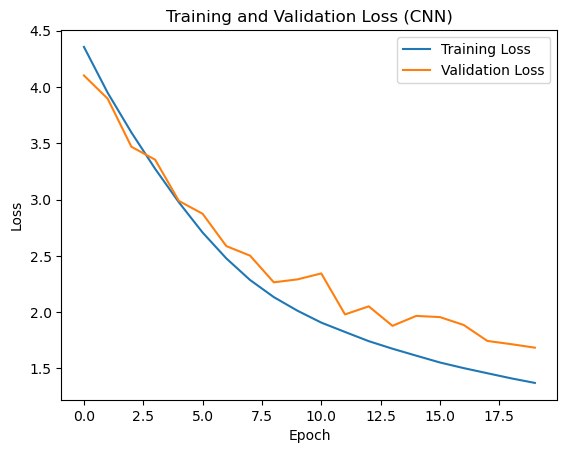

In [7]:
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (CNN)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Accuracy metrics on test set

In [8]:
# Evaluate the model on the test dataset
print("Model: CNN")
cnn_test_loss, cnn_test_accuracy = model.evaluate(tf_dataset_test)
print(f"Test Loss: {cnn_test_loss}")
print(f"Test Accuracy: {cnn_test_accuracy}")

true = []
predicted = []
for images, labels in tf_dataset_test:
    predictions = model.predict(images, verbose=0)
    true.extend(labels.numpy())
    predicted.extend(np.argmax(predictions, axis=1))

print(classification_report(true, predicted))

Model: CNN


401/401 [==============================] - 38s 94ms/step - loss: 1.5639 - accuracy: 0.6225
Test Loss: 1.563905954360962
Test Accuracy: 0.622475266456604
              precision    recall  f1-score   support

           0       0.44      0.34      0.39      4418
           1       0.69      0.77      0.73      8405

    accuracy                           0.62     12823
   macro avg       0.56      0.56      0.56     12823
weighted avg       0.60      0.62      0.61     12823



# Transfer learning task

**EfficientNetB0**

In [9]:
# Define the input layer
input_layer = Input(shape=(100, 100, 3))

# Load the EfficientNetB0 base model
efficientnet_base = EfficientNetB0(include_top=False, input_shape=(100, 100, 3), weights='imagenet', pooling='avg')
efficientnet_base.trainable = False

# Add additional layers on top of the base model
x = efficientnet_base(input_layer)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(2, activation='softmax')(x)

# Creating the model
effnet_model = Model(inputs=input_layer, outputs=output_layer)

# Compiling the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.000001)
effnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Setting up callbacks
checkpoint_callback = ModelCheckpoint('effnet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Training the model
effnet_history = effnet_model.fit(tf_dataset_train, epochs=20, batch_size=5, validation_data=tf_dataset_val, callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/20


2023-12-11 15:11:32.110530: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


928/928 [==============================] - ETA: 0s - loss: 0.8305 - accuracy: 0.4922
Epoch 1: val_loss improved from inf to 0.70307, saving model to effnet.h5
928/928 [==============================] - 135s 138ms/step - loss: 0.8305 - accuracy: 0.4922 - val_loss: 0.7031 - val_accuracy: 0.3218
Epoch 2/20
926/928 [============================>.] - ETA: 0s - loss: 0.7654 - accuracy: 0.4969
Epoch 2: val_loss improved from 0.70307 to 0.69954, saving model to effnet.h5
928/928 [==============================] - 126s 135ms/step - loss: 0.7654 - accuracy: 0.4970 - val_loss: 0.6995 - val_accuracy: 0.3220
Epoch 3/20
925/928 [============================>.] - ETA: 0s - loss: 0.7547 - accuracy: 0.5038
Epoch 3: val_loss improved from 0.69954 to 0.68785, saving model to effnet.h5
928/928 [==============================] - 128s 138ms/step - loss: 0.7547 - accuracy: 0.5037 - val_loss: 0.6878 - val_accuracy: 0.6753
Epoch 4/20
926/928 [============================>.] - ETA: 0s - loss: 0.7523 - accuracy:

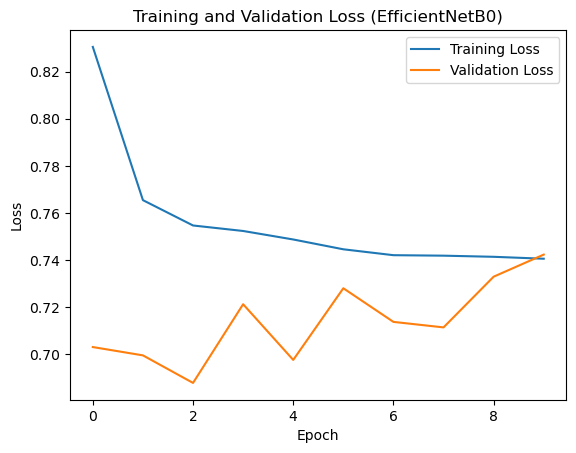

In [10]:
plt.plot(effnet_history.history['loss'], label='Training Loss')
plt.plot(effnet_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (EfficientNetB0)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [11]:
# Evaluate the model on the test dataset
print("Model: EfficientNetB0")
effnet_test_loss, effnet_test_accuracy = effnet_model.evaluate(tf_dataset_test, batch_size=5)
print(f"Test Loss: {effnet_test_loss}")
print(f"Test Accuracy: {effnet_test_accuracy}")

true = []
predicted = []
for images, labels in tf_dataset_test:
    predictions = effnet_model.predict(images, verbose=0)
    true.extend(labels.numpy())
    predicted.extend(np.argmax(predictions, axis=1))

print(classification_report(true, predicted))

Model: EfficientNetB0
401/401 [==============================] - 39s 97ms/step - loss: 0.6965 - accuracy: 0.3841
Test Loss: 0.6965370178222656
Test Accuracy: 0.38407549262046814
              precision    recall  f1-score   support

           0       0.36      1.00      0.53      4418
           1       0.97      0.06      0.12      8405

    accuracy                           0.38     12823
   macro avg       0.66      0.53      0.32     12823
weighted avg       0.76      0.38      0.26     12823



**ResNet50**

In [12]:
# Define the input layer
input_layer = Input(shape=(100, 100, 3))

# Load the ResNet50 base model
resnet_base = ResNet50(include_top=False, input_shape=(100, 100, 3), weights='imagenet', pooling='avg')
resnet_base.trainable = False

# Add additional layers on top of the base model
x = resnet_base(input_layer)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(2, activation='softmax')(x)

# Create the model
resnet_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
checkpoint_callback = ModelCheckpoint('resnet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
resnet_history = resnet_model.fit(tf_dataset_train, epochs=20, batch_size=5, validation_data=tf_dataset_val, callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.6130
Epoch 1: val_loss improved from inf to 0.63525, saving model to resnet.h5
928/928 [==============================] - 139s 145ms/step - loss: 0.6708 - accuracy: 0.6130 - val_loss: 0.6352 - val_accuracy: 0.6795
Epoch 2/20
926/928 [============================>.] - ETA: 0s - loss: 0.6550 - accuracy: 0.6354
Epoch 2: val_loss improved from 0.63525 to 0.51316, saving model to resnet.h5
928/928 [==============================] - 132s 142ms/step - loss: 0.6550 - accuracy: 0.6353 - val_loss: 0.5132 - val_accuracy: 0.7803
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 0.6413 - accuracy: 0.6459
Epoch 3: val_loss did not improve from 0.51316
928/928 [==============================] - 132s 142ms/step - loss: 0.6413 - accuracy: 0.6459 - val_loss: 0.5380 - val_accuracy: 0.7688
Epoch 4/20
928/928 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.6568
Epoch 4: val

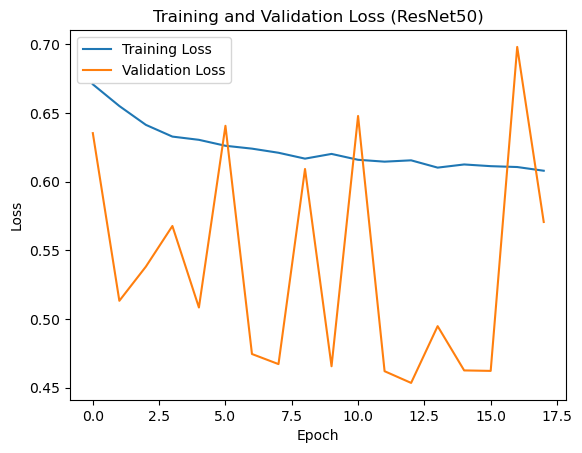

In [13]:
plt.plot(resnet_history.history['loss'], label='Training Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (ResNet50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
# Evaluate the model on the test dataset
print("Model: ResNet50")
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(tf_dataset_test, batch_size=5)
print(f"Test Loss: {resnet_test_loss}")
print(f"Test Accuracy: {resnet_test_accuracy}")

true = []
predicted = []
for images, labels in tf_dataset_test:
    predictions = resnet_model.predict(images, verbose=0)
    true.extend(labels.numpy())
    predicted.extend(np.argmax(predictions, axis=1))

print(classification_report(true, predicted))

Model: ResNet50
401/401 [==============================] - 41s 100ms/step - loss: 0.8730 - accuracy: 0.4939
Test Loss: 0.8730243444442749
Test Accuracy: 0.49387818574905396
              precision    recall  f1-score   support

           0       0.40      0.98      0.57      4418
           1       0.96      0.24      0.38      8405

    accuracy                           0.49     12823
   macro avg       0.68      0.61      0.48     12823
weighted avg       0.77      0.49      0.45     12823



**VGG16**

In [15]:
# Define the input layer
input_layer = Input(shape=(100, 100, 3))

# Load the VGG16 base model
vgg_base = VGG16(include_top=False, input_shape=(100, 100, 3), weights='imagenet', pooling='avg')
vgg_base.trainable = False

# Add additional layers on top of the base model
x = vgg_base(input_layer)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(2, activation='softmax')(x)

# Create the model
vgg_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
vgg_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('vgg.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model
vgg_history = vgg_model.fit(tf_dataset_train, epochs=20, batch_size=5, validation_data=tf_dataset_val, callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.7487
Epoch 1: val_loss improved from inf to 0.68819, saving model to vgg.h5
928/928 [==============================] - 138s 146ms/step - loss: 0.5042 - accuracy: 0.7487 - val_loss: 0.6882 - val_accuracy: 0.6374
Epoch 2/20
925/928 [============================>.] - ETA: 0s - loss: 0.4637 - accuracy: 0.7738
Epoch 2: val_loss did not improve from 0.68819
928/928 [==============================] - 132s 142ms/step - loss: 0.4640 - accuracy: 0.7737 - val_loss: 0.8359 - val_accuracy: 0.5797
Epoch 3/20
926/928 [============================>.] - ETA: 0s - loss: 0.4606 - accuracy: 0.7761
Epoch 3: val_loss did not improve from 0.68819
928/928 [==============================] - 133s 143ms/step - loss: 0.4607 - accuracy: 0.7760 - val_loss: 1.0228 - val_accuracy: 0.5276
Epoch 4/20
925/928 [============================>.] - ETA: 0s - loss: 0.4532 - accuracy: 0.7816
Epoch 4: val_loss improved from 0.68819 to 0.6

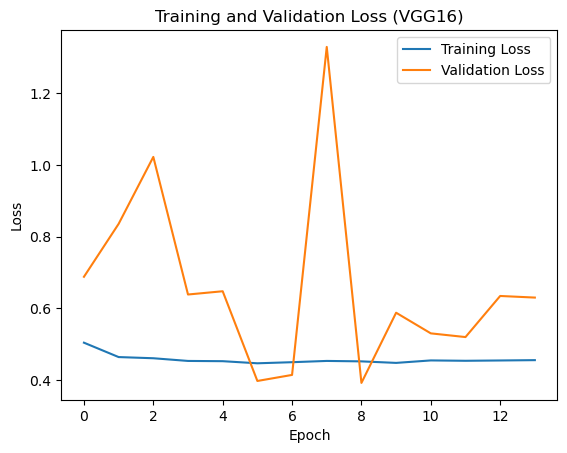

In [16]:
plt.plot(vgg_history.history['loss'], label='Training Loss')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (VGG16)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [17]:
# Evaluate the model on the test dataset
print("Model: VGG16")
vgg_test_loss, vgg_test_accuracy = vgg_model.evaluate(tf_dataset_test, batch_size=5)
print(f"Test Loss: {vgg_test_loss}")
print(f"Test Accuracy: {vgg_test_accuracy}")

true = []
predicted = []
for images, labels in tf_dataset_test:
    predictions = vgg_model.predict(images, verbose=0)
    true.extend(labels.numpy())
    predicted.extend(np.argmax(predictions, axis=1))

print(classification_report(true, predicted))

Model: VGG16
401/401 [==============================] - 42s 102ms/step - loss: 0.6595 - accuracy: 0.7283
Test Loss: 0.6594646573066711
Test Accuracy: 0.7283006906509399
              precision    recall  f1-score   support

           0       0.56      0.96      0.71      4418
           1       0.97      0.61      0.75      8405

    accuracy                           0.73     12823
   macro avg       0.76      0.78      0.73     12823
weighted avg       0.83      0.73      0.73     12823



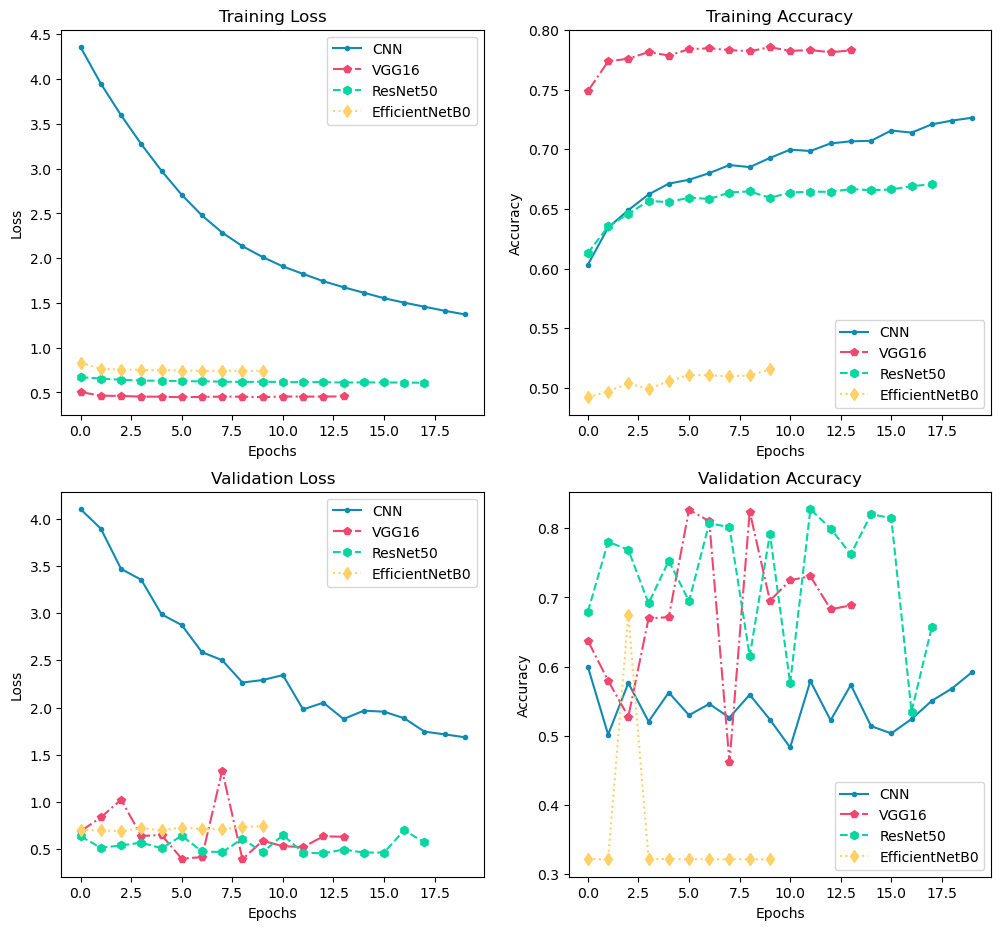

In [26]:
# Compare all 4 models' performance

# Traninng loss
plt.figure(figsize=(12, 11))
plt.subplot(2, 2, 1)
plt.plot(cnn_history.history['loss'], linestyle='solid', marker='.', color='#118AB2', label='CNN')
plt.plot(vgg_history.history['loss'], linestyle='dashdot', marker='p', color='#EF476F', label='VGG16')
plt.plot(resnet_history.history['loss'], linestyle='dashed', marker='h', color='#06D6A0', label='ResNet50')
plt.plot(effnet_history.history['loss'], linestyle='dotted', marker='d', color='#FFD166', label='EfficientNetB0')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(cnn_history.history['accuracy'], linestyle='solid', marker='.', color='#118AB2', label='CNN')
plt.plot(vgg_history.history['accuracy'], linestyle='dashdot', marker='p', color='#EF476F', label='VGG16')
plt.plot(resnet_history.history['accuracy'], linestyle='dashed', marker='h', color='#06D6A0', label='ResNet50')
plt.plot(effnet_history.history['accuracy'], linestyle='dotted', marker='d', color='#FFD166', label='EfficientNetB0')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Validation loss
plt.subplot(2, 2, 3)
plt.plot(cnn_history.history['val_loss'], linestyle='solid', marker='.', color='#118AB2', label='CNN')
plt.plot(vgg_history.history['val_loss'], linestyle='dashdot', marker='p', color='#EF476F', label='VGG16')
plt.plot(resnet_history.history['val_loss'], linestyle='dashed', marker='h', color='#06D6A0', label='ResNet50')
plt.plot(effnet_history.history['val_loss'], linestyle='dotted', marker='d', color='#FFD166', label='EfficientNetB0')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(cnn_history.history['val_accuracy'], linestyle='solid', marker='.', color='#118AB2', label='CNN')
plt.plot(vgg_history.history['val_accuracy'], linestyle='dashdot', marker='p', color='#EF476F', label='VGG16')
plt.plot(resnet_history.history['val_accuracy'], linestyle='dashed', marker='h', color='#06D6A0', label='ResNet50')
plt.plot(effnet_history.history['val_accuracy'], linestyle='dotted', marker='d', color='#FFD166', label='EfficientNetB0')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [29]:
# Compare testing perforamnce
print('Model \t\t Test Loss \t\t Test Accuracy')
print(f'CNN \t\t {cnn_test_loss:.4f} \t\t {cnn_test_accuracy:.4f}')
print(f'VGG16 \t\t {vgg_test_loss:.4f} \t\t {vgg_test_accuracy:.4f}')
print(f'ResNet50 \t {resnet_test_loss:.4f} \t\t {resnet_test_accuracy:.4f}')
print(f'EfficientNetB0 \t {effnet_test_loss:.4f} \t\t {effnet_test_accuracy:.4f}')

Model 		 Test Loss 		 Test Accuracy
CNN 		 1.5639 		 0.6225
VGG16 		 0.6595 		 0.7283
ResNet50 	 0.8730 		 0.4939
EfficientNetB0 	 0.6965 		 0.3841
